In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import *
π = pi
import matplotlib.animation as mplanim 
plt.rc('animation', html='jshtml')
from typing import Callable
from scipy import integrate
from scipy import optimize
import scipy.special as ss
from mpl_toolkits.axes_grid1 import AxesGrid
#%config InlineBackend.figure_formats = ['svg']

## Plots of non-interacting Green function in Matsubara time

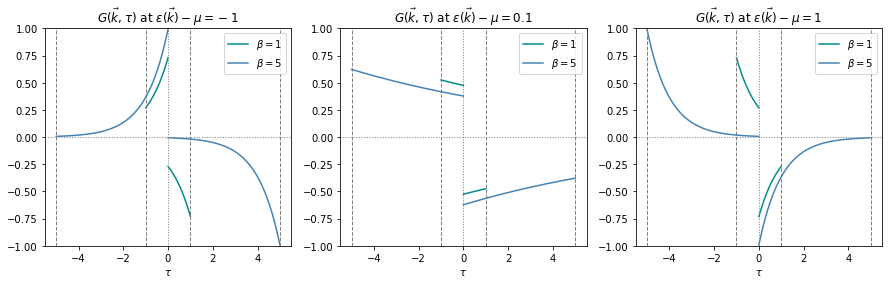

In [66]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))

beta=10
def f (e,beta):
    return 1/(1+np.exp(beta*e))
def Gtau (tau, ek, beta):
    return -np.exp(-ek*tau) * ( (1-f(ek,beta))*np.heaviside(tau,1) - f(ek,beta)*np.heaviside(-tau,1) )
#def Gtau (tau, ek, beta):
#    return -np.exp(-ek*(tau-beta)) * f(ek,beta)

for ek,ax in zip([-1,0.1,1],axes):
    for beta,color in zip([1,5],['darkcyan','steelblue']):
        tau = np.linspace(-beta,-1e-10,500)
        ax.plot(tau, Gtau(tau, ek, beta), color=color, label=r"$\beta={}$".format(beta))
        tau = np.linspace(1e-10,beta,500)
        ax.plot(tau, Gtau(tau, ek, beta), color=color)
        ax.axvline(x=-beta, linestyle='--', lw=1, color='gray')
        ax.axvline(x=+beta, linestyle='--', lw=1, color='gray')
    ax.axvline(x=0, linestyle='dotted', lw=1, color='gray')
    ax.axhline(y=0, linestyle='dotted', lw=1, color='gray')
    ax.set_title(r"$G(\vec{{k}},\tau)$ at $\epsilon(\vec{{k}})-\mu={}$".format(ek))
    ax.set_ylim((-1,1))
    ax.set_xlabel(r"$\tau$")
    ax.legend()
plt.savefig("green-func-non-interacting.pdf", bbox_inches="tight")

# Unit tests for Green functions

In [2]:
def ωn (β:float, n:int) -> float:
    return (2*n+1)*π / β

def greenmatsubara_time_to_freq (β:float, dτ:float, Gτ:np.array) -> Callable[[int],complex]:
    τ = np.arange(0, β+1e-10, dτ)
    # between 0 and β integrate G(τ) exp(i.ωn.τ)
    f = lambda n: dτ * np.sum( np.exp(1j*ωn(β,n)*τ) * Gτ )
    return np.vectorize(f)

def greenmatsubara_freq_to_time (β:float, iωn:np.array, Giωn:np.array, halfiωn=False) -> Callable[[float],float]:
    # if halfiωn=False, Giωn should have an even size 2N, corresponding to n's in [-n,n[ (eg. [-1,0], [-2,-1,0,1]...)
    #                   ( n = np.arange(-len(Giωn)//2, len(Giωn)//2) )
    # if halfiωn=True, Giωn should have a size N, corresponding to n's in [0,N[
    if halfiωn:
        f = lambda τ: 2/β * np.sum( np.real( np.exp(-iωn*τ) * Giωn_sing ) )
    else:
        f = lambda τ: 1/β * np.sum(          np.exp(-iωn*τ) * Giωn )
    return np.vectorize(f)

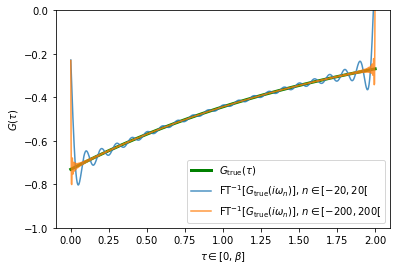

In [33]:
def test_Giωn_1 (β, iωn, ξ):
    return 1 / ( iωn - ξ )

def test_Gτ_1 (β, τ, ξ):
    return -np.exp(ξ*(β-τ)) / ( np.exp(β*ξ) + 1 )

β = 2
τ = np.linspace(0,β,1000)
dτ = τ[1] - τ[0]
ξ = 0.5

plt.plot( τ, test_Gτ_1(β,τ,ξ), label=r"$G_\operatorname{true}(\tau)$", color='green', lw=3 )
plt.ylim((-1,0))

for ncut in [20,200]:
    n = np.arange(-ncut,ncut)
    iωn = 1j*ωn(β,n)
    test_Gτ_1_tr = greenmatsubara_freq_to_time(β, iωn, Giωn=test_Giωn_1(β,iωn,ξ))
    plt.plot(τ,test_Gτ_1_tr(τ), label=r"$\operatorname{FT}^{-1}[ G_\operatorname{true}(i\omega_n) ]$"+r", $n\in[-{ncut},{ncut}[$".format(ncut=ncut), alpha=0.8)

plt.legend()
plt.xlabel(r"$\tau \in [0,\beta]$")
plt.ylabel(r"$G(\tau)$");
#plt.savefig("green-tau-ringing.pdf", bbox_inches='tight')

In [57]:
np.linalg.norm(np.imag(test_Gτ_1_tr(τ)), ord=np.inf)

0.04179851889130457

Ok, this is bad. We need to singularize the $1/\mathrm{i}\omega_n$ term.

In [3]:
def greenmatsubara_freq_to_time_sing (β:float, iωn:np.array, Giωn_sing:np.array, halfiωn=False) -> Callable[[float],float]:
    # if halfiωn=False, Giωn should have an even size 2N, corresponding to n's in [-n,n[ (eg. [-1,0], [-2,-1,0,1]...)
    #                   ( n = np.arange(-len(Giωn_sing)//2, len(Giωn_sing)//2) )
    # if halfiωn=True, Giωn should have a size N, corresponding to n's in [0,N[
    if halfiωn:
        f = lambda τ: 2/β * np.sum( np.real( np.exp(-iωn*τ) * Giωn_sing ) ) -1/2
    else:
        f = lambda τ: 1/β * np.sum(          np.exp(-iωn*τ) * Giωn_sing ) -1/2
    return np.vectorize(f)

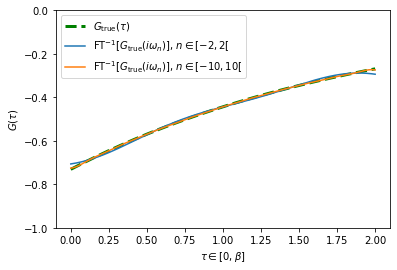

In [32]:
def test_Giωn_1_sing (β, iωn, ξ):
    return 1/( iωn - ξ ) - 1/iωn

plt.plot( τ, test_Gτ_1(β,τ,ξ), '--', label=r"$G_\operatorname{true}(\tau)$", color='green', lw=3 )
plt.ylim((-1,0))

for ncut in [2, 10]:
    n = np.arange(-ncut,ncut)
    iωn = 1j*ωn(β,n)
    test_Gτ_1_tr = greenmatsubara_freq_to_time_sing(β, iωn, test_Giωn_1_sing(β,iωn,ξ))
    # or with only positive frequencies :
    # n = np.arange(0,ncut)
    # iωn = 1j*ωn(β,n)
    # test_Gτ_1_tr = greenmatsubara_freq_to_time_sing(β, iωn, test_Giωn_1_sing(β,iωn,ξ), halfiωn=True)
    plt.plot(τ,test_Gτ_1_tr(τ), label=r"$\operatorname{FT}^{-1}[ G_\operatorname{true}(i\omega_n) ]$"+r", $n\in[-{ncut},{ncut}[$".format(ncut=ncut))

plt.legend()
plt.xlabel(r"$\tau \in [0,\beta]$")
plt.ylabel(r"$G(\tau)$");
#plt.savefig("green-tau-singularized.pdf", bbox_inches='tight')

Muuuuuuuuuuch better. Even $n=2$ works ok !

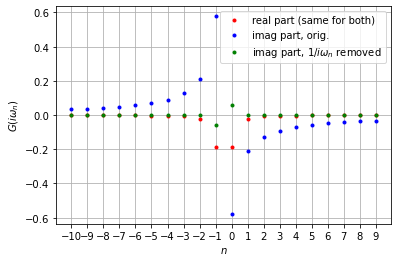

In [34]:
n = np.arange(-10,+10)
iωn = 1j*ωn(β,n)
plt.plot(n, np.real(test_Giωn_1(β,iωn,ξ)), '.', label="real part (same for both)", color='red')
plt.plot(n, np.imag(test_Giωn_1(β,iωn,ξ)), '.', label="imag part, orig.", color='blue')
plt.plot(n, np.imag(test_Giωn_1_sing(β,iωn,ξ)), '.', label=r"imag part, $1/i\omega_n$ removed", color='green')
plt.legend()
plt.xlabel("$n$")
plt.xticks(n)
plt.ylabel(r"$G(i\omega_n)$")
plt.grid();

Now let's check the other way around.

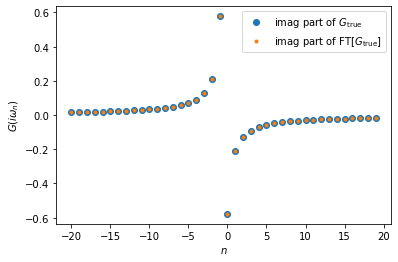

In [35]:
n = np.arange(-20,20)
iωn = 1j*ωn(β,n)
test_Giωn_1_tr = greenmatsubara_time_to_freq(β, dτ, test_Gτ_1(β,τ,ξ))
plt.plot(n, np.imag(test_Giωn_1(β,iωn,ξ)), 'o', label="imag part of $G_\operatorname{true}$")
plt.plot(n, np.imag(test_Giωn_1_tr(n)), '.', label=r"imag part of $\operatorname{FT}[G_\operatorname{true}]$")
plt.legend()
plt.xlabel("$n$")
plt.ylabel(r"$G(i\omega_n)$");

### Atomic limit

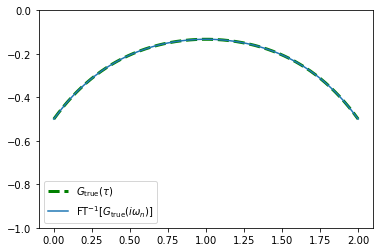

In [37]:
def Giωn_at (β, iωn, U):
    return 1/2 / ( iωn - U/2 ) + 1/2 / ( iωn + U/2 )

def Gτ_at (β, τ, U):
    return -1/2 * np.exp(-τ*U/2) / ( np.exp(-β*U/2) + 1 ) -1/2 * np.exp(+τ*U/2) / ( np.exp(+β*U/2) + 1 )

U = 4

plt.plot( τ, Gτ_at(β,τ,U), '--', label=r"$G_\operatorname{true}(\tau)$", color='green', lw=3 )
plt.ylim((-1,0))

n = np.arange(-10,10)
iωn = 1j*ωn(β,n)
Gτ_at_tr = greenmatsubara_freq_to_time_sing(β, iωn, Giωn_at(β,iωn,U)-1/iωn)
plt.plot(τ,Gτ_at_tr(τ), label=r"$\operatorname{FT}^{-1}[ G_\operatorname{true}(i\omega_n) ]$")

plt.legend();

Self energy $\Sigma = G_0^{-1} - G^{-1}$ in $\mathrm{i}\omega_n$ :

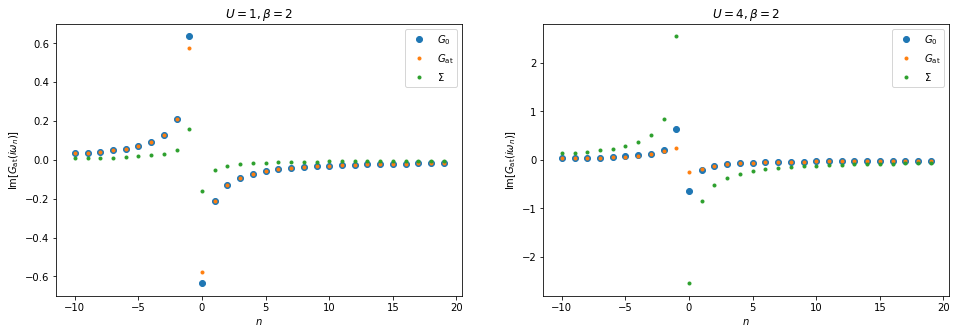

In [38]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(16,5))
n = np.arange(-10,20)
iωn = 1j*ωn(β,n)
for U,ax in zip([1, 4], [ax1,ax2]):
    G0 = 1/iωn
    Gat = Giωn_at(β,iωn,U)
    SelfEn = 1/G0 - 1/Gat
    ax.plot(n, np.imag(G0), 'o', label="$G_0$")
    ax.plot(n, np.imag(Gat), '.', label=r"$G_\operatorname{at}$")
    ax.plot(n, np.imag(SelfEn), '.', label=r"$\Sigma$")
    ax.legend()
    ax.set_xlabel("$n$")
    ax.set_ylabel(r"$\operatorname{Im}[ G_\operatorname{at}(i\omega_n) ]$");
    ax.set_title(r"$U={}, \beta=2$".format(U))

## On a lattice

In [4]:
# t = 1 implicitely here, for the Bethe lattice

def latt_Bethe_DoS (ϵ:float) -> float:
    return 1/(2*π) * np.sqrt(4-ϵ**2)

# with "where the sign of the imaginary part of the square root is the same as the sign of Im{z}"
def latt_Bethe_hilbert (z:complex) -> complex:
    inside = 0j+(z)**2-4
    sqroot = np.sqrt(inside)
    sqroot = np.real(sqroot) + 1j*np.copysign(np.imag(sqroot), np.imag(z))
    return (z-sqroot)/2

# with s=sgn(Re(z))
def latt_Bethe_hilbert (z:complex) -> complex:
    inside = 0j+(z+1e-40)**2-4
    s = np.sign(np.real(z+1e-40))
    return (z-s*np.sqrt(inside))/2

def latt_Bethe_hilbert_deriv (z:complex) -> complex:
    inside = 0j+(z+1e-40)**2-4
    s = np.sign(np.real(z+1e-40))
    return (1-s*z/np.sqrt(inside))/2

Just to check if the formula for `latt_Bethe_hilbert` is right :

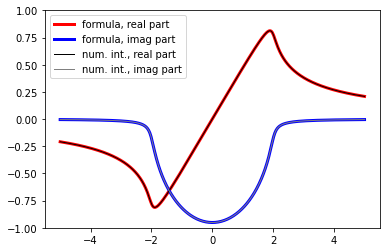

In [20]:
Z = -1 * np.linspace(-5,+5,500) - 0.1j
I = []
for z in Z:
    f = lambda e: np.sqrt(4-e**2)/(2*pi) / (z-e)
    i = 0
    delta = 0.01
#    if z < 2 and z > -2:
#        i = integrate.quad(f, a=-2, b=z-delta)[0] + integrate.quad(f, a=z+delta, b=2)[0]
#    else:
    if True:
        i  =    integrate.quad(lambda e: np.real(f(e)), a=-2, b=2)[0]
        i += 1j*integrate.quad(lambda e: np.imag(f(e)), a=-2, b=2)[0]
    I.append( i )
plt.plot(np.real(Z), np.real(latt_Bethe_hilbert(Z)), color='red', lw=3, label="formula, real part")
plt.plot(np.real(Z), np.imag(latt_Bethe_hilbert(Z)), color='blue', lw=3, label="formula, imag part")
plt.plot(np.real(Z), np.real(I), color='black', lw=1, label="num. int., real part")
plt.plot(np.real(Z), np.imag(I), color='gray', lw=1, label="num. int., imag part")
plt.ylim(-1,1)
plt.legend();

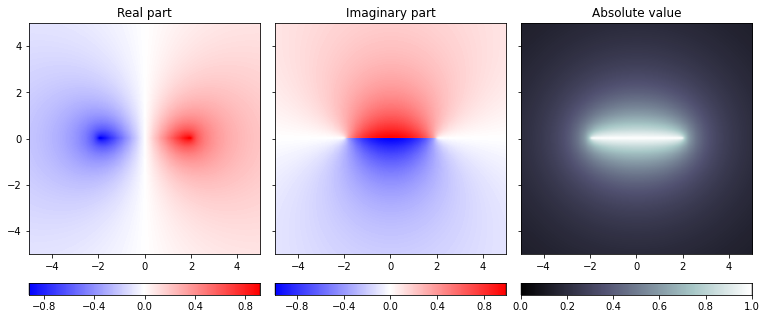

In [157]:
def plot_re_im_abs_complexfunc (func, extent, reso=200):
    fig = plt.figure(figsize=(15,5))
    grid = AxesGrid(fig, 111, nrows_ncols=(1,3), cbar_location="bottom", cbar_mode="each", cbar_pad=0.4, axes_pad=0.2)

    x, y = np.linspace(extent[0],extent[1],reso), np.linspace(extent[2],extent[3],reso)
    X,Y = np.meshgrid(x,y)
    Z = func(X+1j*Y)

    im = grid[0].imshow( np.real(Z) , extent=extent, cmap='bwr')
    grid.cbar_axes[0].colorbar(im)
    grid[0].set_title("Real part")

    im = grid[1].imshow( np.imag(Z) , extent=extent, cmap='bwr')
    grid.cbar_axes[1].colorbar(im)
    grid[1].set_title("Imaginary part")

    Z = np.abs(Z)
    im = grid[2].imshow(Z, extent=extent, cmap='bone', vmin=0, vmax=round(np.max(Z),1))
    grid.cbar_axes[2].colorbar(im)
    grid[2].set_title("Absolute value")

plot_re_im_abs_complexfunc(latt_Bethe_hilbert, extent=(-5,+5,-5,+5))
    

Looks like it's bijective on $\mathbb{C} \to \{ |z| \leq 1 \}$.

In [5]:
def latt_Bethe_R (η:complex) -> complex:
    if np.any(np.abs(η)>1):
        raise ValueError("the reciprocal Hilbert transform for the Bethe lattice is defined only on {|z|<1}")
    return η + 1/η

Numerical computation of the reciprocal of the Hilbert transform, using `scipy.optimize.brute`, then `scipy.optimize.fmin` and finally `scipy.optimize.newton` if a derivative is available. (After-tought : this is totally useless, the DMFT loop with $\Sigma$ solves the problem already...)

In [6]:
def latt_R_numrecip (latt_hilbert, latt_hilbert_deriv, η):
    f = lambda z: np.abs(latt_hilbert(z[0]+1j*z[1])-η)
    z = optimize.brute(f, finish=optimize.fmin, ranges=[(-4,4),(-4,4)], Ns=30)
    z = z[0]+1j*z[1]
    if latt_hilbert_deriv is not None:
        try:
            z = optimize.newton(lambda z: latt_hilbert(z)-η, fprime=latt_hilbert_deriv, x0=z)
        except RuntimeError:
            pass
    return z

Let's benchmark it on the Bethe lattice, against the analytical formula :

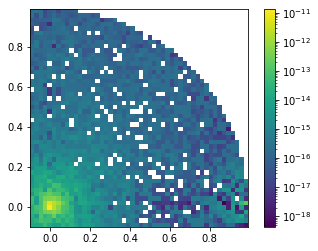

In [196]:
x = np.linspace(-0.1, 0.99, 50)
y = np.linspace(-0.1, 0.99, 50)
X,Y = np.meshgrid(x,y)
def f (η):
    if np.abs(η) < 1:
        return np.abs( latt_R_numrecip(latt_Bethe_hilbert,latt_Bethe_hilbert_deriv,η) - latt_Bethe_R(η) )
    else:
        return np.nan
f = np.vectorize(f)
Z = f(X+1j*Y)
plt.imshow(Z, extent=(-0.1,0.99,-0.1,0.99), origin='lower', norm=mpl.colors.LogNorm())
plt.colorbar()

Infinite-dimensional cubic lattice :

In [7]:
def latt_cubic_hilbert (z:complex) -> complex:
    def asympt (z):
        return 1/z + 1/(2*z**3) + 3/(4*z**5)
    def exact (z):
        s = np.sign(np.imag(z))
        return -1j*s * np.exp(-z**2) * ss.erfc(-1j*s*z) * sqrt(π)
    core = np.abs(z) < 20
    res = asympt(z)
    res[core] = exact(z[core])
    return res

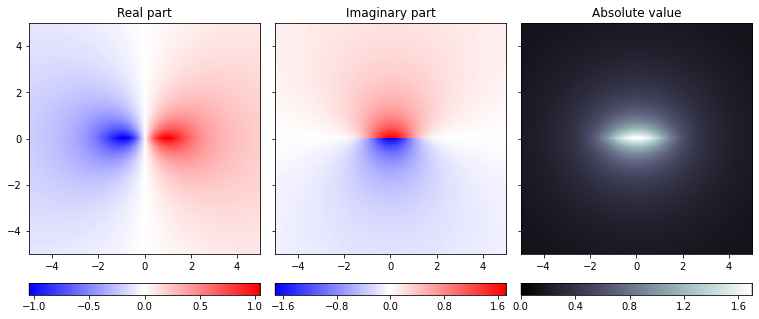

In [180]:
plot_re_im_abs_complexfunc(latt_cubic_hilbert, extent=(-5,+5,-5,+5))

At $U=0$ :

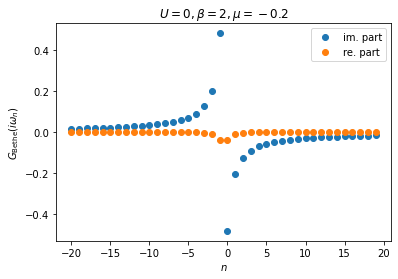

In [164]:
def G0_loc_iωn (latt_hilbert, iωn, µ):
    return latt_hilbert(iωn+µ)

β = 2
n = np.arange(-20,20)
iωn = 1j*ωn(β,n)
µ = -0.2

G0_iωn_Bethe = G0_loc_iωn(latt_Bethe_hilbert, iωn, µ)

plt.plot(n, np.imag(G0_iωn_Bethe), 'o', label='im. part')
plt.plot(n, np.real(G0_iωn_Bethe), 'o', label='re. part')
plt.xlabel("$n$")
plt.ylabel(r"$G_\operatorname{Bethe}(i\omega_n)$")
plt.legend()
plt.title(r"$U=0, \beta={}, \mu={}$".format(β,µ));

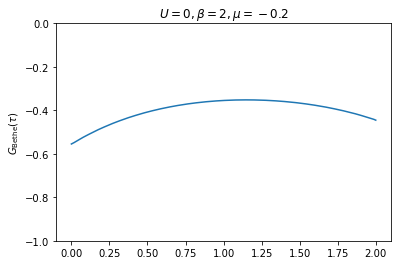

In [10]:
Gτ_Bethe = greenmatsubara_freq_to_time_sing(β, iωn, G0_iωn_Bethe-1/iωn)
τ = np.linspace(0,β,1000)
plt.plot(τ,Gτ_Bethe(τ))

plt.ylim((-1,0))
plt.ylabel(r"$G_\operatorname{Bethe}(\tau)$")
plt.title(r"$U=0, \beta={}, \mu={}$".format(β,µ));

At $U\neq 0$ : the DMFT loop :

In [8]:
# eq (self-consistent-eq-reciproc-Hilbert-fromcavity)

def imp_Gbath_from_Gloc (R:Callable[[complex],complex], iωn:np.array, Gloc_iωn:np.array, µ:float) -> np.array:
    return 1 /( iωn + µ + 1/Gloc_iωn - R(Gloc_iωn) )

In [9]:
def impurity_solver_IPT (β:float, U:float, iωn:np.array, Gbath_iωn:np.array, dτ=1e-3) -> Callable[[int],complex]:
    # Gbath_iωn should have an even size 2N, corresponding to n's in [-N,N[ (eg. [-1,0], [-2,-1,0,1]...)
    Gbath_shift_iωn = 1/( 1/Gbath_iωn - U/2 )
    τ = np.arange(0, β+1e-10, dτ)
    Gbath_shift_τ = greenmatsubara_freq_to_time_sing(β, iωn, Gbath_shift_iωn-1/iωn)
    Gbath_shift_τ = Gbath_shift_τ(τ)
                                   # between 0 and β integrate G(τ)^3 exp(i.ωn.τ)
    f = lambda n: U/2 + (U/2)**2 * dτ * np.sum( np.exp(1j*ωn(β,n)*τ) * Gbath_shift_τ )
    return np.vectorize(f)

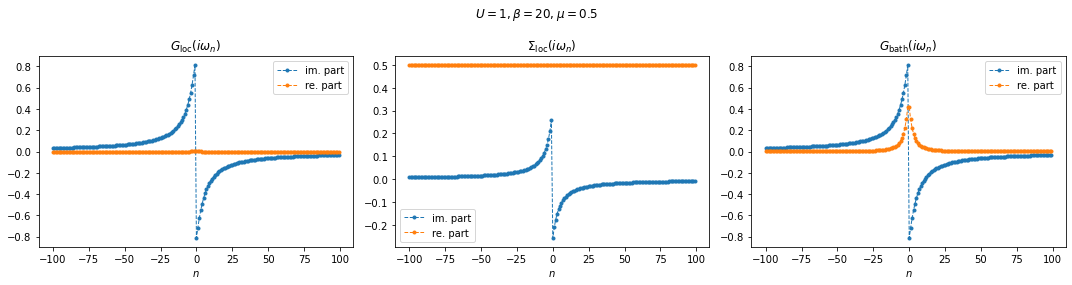

In [165]:
β = 20
U = 1
µ = U/2
n = np.arange(-100,100) # np.arange(-300,300)
iωn = 1j*ωn(β,n)

Gloc_iωn = G0_loc_iωn(latt_Bethe_hilbert, iωn, µ)

def plot_Giωn (ax, G_iωn, it, name="G"):
    ax.plot(n, np.imag(G_iωn), '.--', lw=1, label='im. part')
    ax.plot(n, np.real(G_iωn), '.--', lw=1, label='re. part')
    ax.set_xlabel("$n$")
    ax.set_title("$"+name+r"(i\omega_n)$")
    ax.legend()

γ = 0.9

for it in range(100):

    # DMFT loop
    Gbath_iωn = imp_Gbath_from_Gloc (latt_Bethe_R, iωn, Gloc_iωn, µ)
    Σloc_iωn = impurity_solver_IPT (β, U, iωn, Gbath_iωn)
    Σloc_iωn = Σloc_iωn(n)
    Gloc_iωn_new = 1 / ( 1/Gbath_iωn - Σloc_iωn )
    # or : Gloc_iωn_new = latt_Bethe_hilbert( iωn + µ - Σloc_iωn )

    if False:
        fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,4))
        plot_Giωn(ax1, Gloc_iωn, it, "G_\operatorname{loc,before}")
        plot_Giωn(ax2, Gbath_iωn, it, "G_\operatorname{bath}")
        plot_Giωn(ax3, Σloc_iωn, it, "\Sigma_\operatorname{imp}")
        fig.suptitle(r"$U={}, \beta={}, \mu={}$, iteration {}".format(U,β,µ,it))
        fig.tight_layout()

    norm1_diff = np.linalg.norm(Gloc_iωn-Gloc_iωn_new, ord=1)
#    print(norm1_diff)
    if norm1_diff < 1e-5:
        Gloc_iωn = Gloc_iωn_new
        break
    Gloc_iωn = (1-γ) * Gloc_iωn + γ * Gloc_iωn_new

Σloc_iωn_loop1 = Σloc_iωn

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,4))
plot_Giωn(ax1, Gloc_iωn, it, "G_\operatorname{loc}")
plot_Giωn(ax2, Σloc_iωn, it, "\Sigma_\operatorname{loc}")
plot_Giωn(ax3, Gbath_iωn, it, "G_\operatorname{bath}")
fig.suptitle(r"$U={}, \beta={}, \mu={}$".format(U,β,µ))
fig.tight_layout()

In [21]:
np.savez("beta1-U1.npz", n=n, iwn=iωn, Gloc=Gloc_iωn)

Alternative DMFT loop (using $\Sigma_\text{loc}(\mathrm{i}\omega_n)$ and $\tilde{\eta}$, rather than $G_\text{loc}(\mathrm{i}\omega_n)$ and $R$) :

In [10]:
# eq (self-consistent-eq-Hilbert-tr-zeta-fromcavity)

def imp_Gbath_from_Σloc (latt_hilbert:Callable[[complex],complex], iωn:np.array, Σloc_iωn:np.array, µ:float) -> np.array:
    z = iωn + µ - Σloc_iωn
    return 1 /( Σloc_iωn + 1/latt_hilbert(z) )

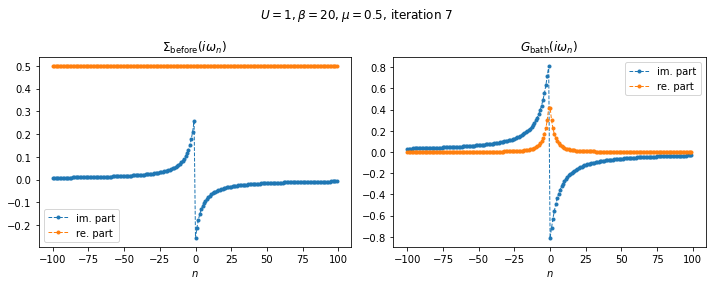

In [168]:
Σloc_iωn = np.zeros_like(iωn) + µ

γ = 0.9

for it in range(100):

    # DMFT loop
    Gbath_iωn = imp_Gbath_from_Σloc (latt_Bethe_hilbert, iωn, Σloc_iωn, µ)
    Σloc_iωn_new = impurity_solver_IPT (β, U, iωn, Gbath_iωn)
    Σloc_iωn_new = Σloc_iωn_new(n)

    if False:
        fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,4))
        plot_Giωn(ax1, Σloc_iωn, it, "\Sigma_\operatorname{before}")
        plot_Giωn(ax2, Gbath_iωn, it, "G_\operatorname{bath}")
        fig.suptitle(r"$U={}, \beta={}, \mu={}$, iteration {}".format(U,β,µ,it))
        fig.tight_layout()

    norm1_diff = np.linalg.norm(Σloc_iωn-Σloc_iωn_new, ord=1)
#    print(norm1_diff)
    if norm1_diff < 1e-5:
        Σloc_iωn = Σloc_iωn_new
        break
    Σloc_iωn = (1-γ) * Σloc_iωn + γ * Σloc_iωn_new

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,4))
plot_Giωn(ax1, Σloc_iωn, it, "\Sigma_\operatorname{before}")
plot_Giωn(ax2, Gbath_iωn, it, "G_\operatorname{bath}")
fig.suptitle(r"$U={}, \beta={}, \mu={}$, iteration {}".format(U,β,µ,it))
fig.tight_layout()

In [193]:
np.linalg.norm(Σloc_iωn - Σloc_iωn_loop1, ord=1)

6.527969888128387e-09

Same result : both loops are indeed equivalent.

### Bath directly from lattice dispersion relation

In [152]:
def imp_Gbath_from_Σloc_disprel (ϵk:np.array, iωn:np.array, Σloc_iωn:np.array, µ:float) -> np.array:
    def h (l,z):
        return np.sum( ϵk**l / (z-ϵk) ) / np.prod(ϵk.shape)
    h = np.vectorize(h)
    z = iωn + µ - Σloc_iωn
    Δ = h(2,z) - h(1,z)**2 / h(0,z)
    return 1/( iωn + µ - Δ )

In [145]:
def ϵk_cubic (d, t, N, ε=0):
    # a = 1
    k1 = np.linspace(-π,+π,N)
    k = np.meshgrid(*([k1]*d))
    ϵk = np.zeros_like(k[0], dtype=complex)
    for l in range(d):
        ϵk += 2 * t[l] * np.cos(k[l])
    ϵk += 2j * ε * np.sin(k[0])
    return ϵk

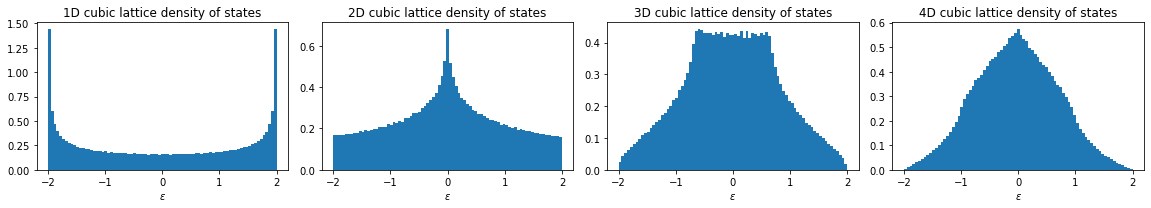

In [122]:
fig, axes = plt.subplots(ncols=4, figsize=(16,3))

for d in [1,2,3,4]:
    t = 1/d
    N = int(4000**(1/sqrt(d)))
    ϵk = ϵk_cubic(d, [t]*d, N)
    axes[d-1].hist(ϵk.reshape((N**d)), bins=81, density=True)
    axes[d-1].set_title("{}D cubic lattice density of states".format(d))
    axes[d-1].set_xlabel(r"$\varepsilon$")

fig.tight_layout()

Let's see if the resulting Hilbert transform is right :

In [159]:
def h0 (z):
    return np.sum( 1 / (z-ϵk) ) / np.prod(ϵk.shape)
h0 = np.vectorize(h0)

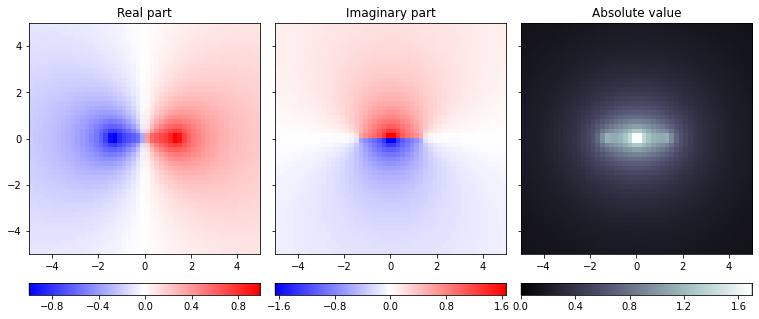

In [160]:
d = 2
ϵk = ϵk_cubic(d, [1/sqrt(d)/2]*d, 100)
plot_re_im_abs_complexfunc(h0, extent=(-5,+5,-5,+5), reso=50)

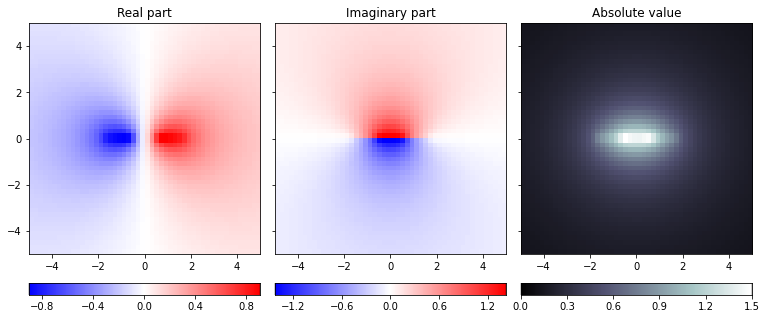

In [173]:
d = 3
ϵk = ϵk_cubic(d, [1/sqrt(d)/2]*d, 60)
plot_re_im_abs_complexfunc(h0, extent=(-5,+5,-5,+5), reso=50)

Indeed, it works. Let's check that the DMFT loop works with `imp_Gbath_from_Σloc_disprel` : 

6.928735589423329
0.8815982875803703
0.130623015655614
0.023412586904500036
0.004974646529566801
0.001184369782636358
0.0003002318341042593
7.854500198630401e-05


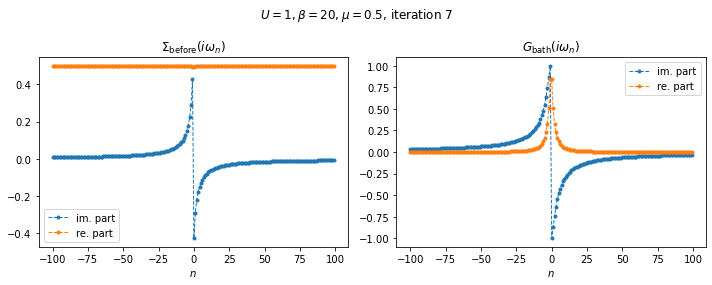

In [174]:
Σloc_iωn = np.zeros_like(iωn) + µ

γ = 0.9

for it in range(20):

    # DMFT loop
    Gbath_iωn = imp_Gbath_from_Σloc_disprel (ϵk, iωn, Σloc_iωn, µ)
    Σloc_iωn_new = impurity_solver_IPT (β, U, iωn, Gbath_iωn)
    Σloc_iωn_new = Σloc_iωn_new(n)

    norm1_diff = np.linalg.norm(Σloc_iωn-Σloc_iωn_new, ord=1)
    print(norm1_diff)
    if norm1_diff < 1e-4:
        Σloc_iωn = Σloc_iωn_new
        break
    Σloc_iωn = (1-γ) * Σloc_iωn + γ * Σloc_iωn_new

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,4))
plot_Giωn(ax1, Σloc_iωn, it, "\Sigma_\operatorname{before}")
plot_Giωn(ax2, Gbath_iωn, it, "G_\operatorname{bath}")
fig.suptitle(r"$U={}, \beta={}, \mu={}$, iteration {}".format(U,β,µ,it))
fig.tight_layout()

Looks ok. Let's do something crazy and add an asymmetric hopping in one direction ($\epsilon'(\vec{k})=2\mathrm{i}\varepsilon\sin(k_1 a) + \epsilon(\vec{k})$)

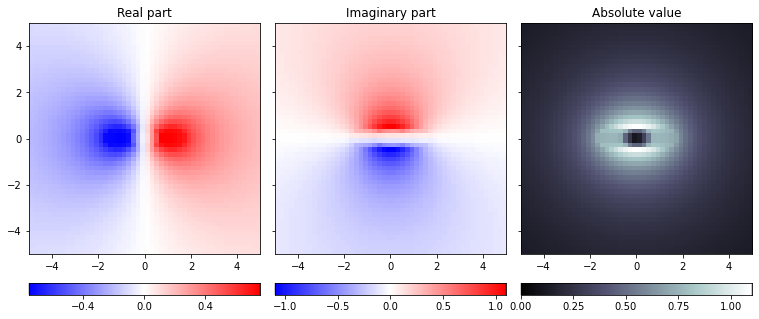

In [175]:
d = 3
ϵk = ϵk_cubic(d, [1/sqrt(d)/2]*d, 60, ε=0.2)
plot_re_im_abs_complexfunc(h0, extent=(-5,+5,-5,+5), reso=50)

6.420317462638296
0.7373063128328575
0.10013709563983914
0.035963205660346886
0.007553690828112599
0.0029409251294835073
0.0007561343661607824
0.00022185524905747657
6.99723662959183e-05


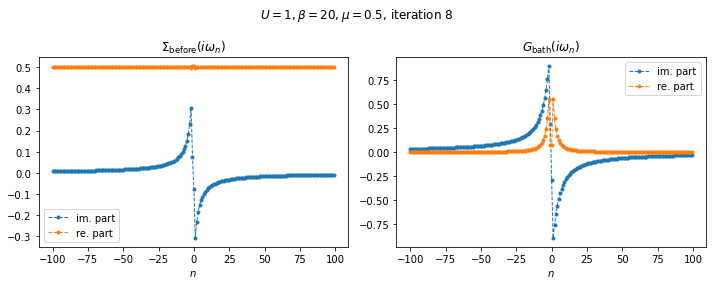

In [176]:
Σloc_iωn = np.zeros_like(iωn) + µ

γ = 0.9

for it in range(20):

    # DMFT loop
    Gbath_iωn = imp_Gbath_from_Σloc_disprel (ϵk, iωn, Σloc_iωn, µ)
    Σloc_iωn_new = impurity_solver_IPT (β, U, iωn, Gbath_iωn)
    Σloc_iωn_new = Σloc_iωn_new(n)

    norm1_diff = np.linalg.norm(Σloc_iωn-Σloc_iωn_new, ord=1)
    print(norm1_diff)
    if norm1_diff < 1e-4:
        Σloc_iωn = Σloc_iωn_new
        break
    Σloc_iωn = (1-γ) * Σloc_iωn + γ * Σloc_iωn_new

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,4))
plot_Giωn(ax1, Σloc_iωn, it, "\Sigma_\operatorname{before}")
plot_Giωn(ax2, Gbath_iωn, it, "G_\operatorname{bath}")
fig.suptitle(r"$U={}, \beta={}, \mu={}$, iteration {}".format(U,β,µ,it))
fig.tight_layout()